In [9]:
import sys
import os
sys.path.append('../')

# Get the current working directory
current_dir = os.getcwd()

# Move one level up to the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Change the working directory to the parent directory
os.chdir(parent_dir)

In [10]:
from segmentation import COCOBuilder

test: 7
Row: 1 / 7

0: 448x640 1 bird, 2799.6ms
Speed: 3.2ms preprocess, 2799.6ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)
Row: 2 / 7

0: 448x640 1 bird, 1841.1ms
Speed: 1.7ms preprocess, 1841.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Row: 3 / 7

0: 640x512 1 bird, 2115.5ms
Speed: 1.8ms preprocess, 2115.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)
Row: 4 / 7

0: 448x640 1 bird, 1965.2ms
Speed: 1.6ms preprocess, 1965.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Row: 5 / 7

0: 448x640 1 bird, 2061.6ms
Speed: 1.8ms preprocess, 2061.6ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Row: 6 / 7

0: 448x640 (no detections), 1915.9ms
Speed: 1.5ms preprocess, 1915.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)
No mask found in result, printing result
Row: 7 / 7

0: 448x640 1 bird, 1529.8ms
Speed: 1.4ms preprocess, 1529.8ms inference, 1.3ms postprocess per i

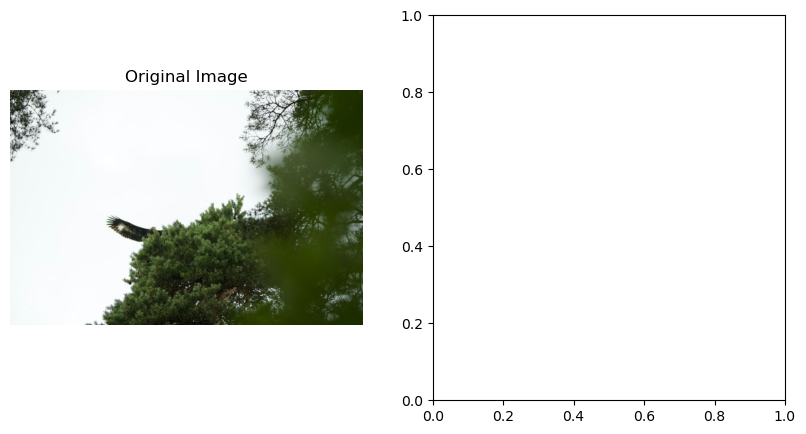

In [11]:
coco = COCOBuilder("./testing/images", testing=True)
coco.setup_testing()
coco.fill_coco()
coco.create_coco_format_json("./testing/coco_training.json")

In [12]:
label_mapping = {0: '1K', 1: '2K', 2: '3K', 3: '4K', 4: '5K_plus'}


In [13]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def unnormalize(x, mean, std):
    """Unnormalize a tensor with the given mean and std"""
    # # Create a new tensor to avoid modifying the original tensor in-place
    # unnormalized_x = x.clone()
    # for t, m, s in zip(unnormalized_x, mean, std):
    #     t = t * s + m  # Out-of-place operations to avoid the in-place issue
    # return unnormalized_x
    unnormalized_x = x.clone().detach()  # Ensure the tensor is detached
    for t, m, s in zip(unnormalized_x, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization
    return unnormalized_x

# Function to visualize GradCAM
def visualize_gradcam(model, image, label, mean, std, target_layer):
    # Enable gradients for the input image
    image.requires_grad_()

    # Get model prediction
    model.eval()
    output = model(image.unsqueeze(0))
    prediction = torch.argmax(output, dim=1).item()

    # Set up GradCAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    targets = [ClassifierOutputTarget(label.item())]

    # Generate GradCAM heatmap
    grayscale_cam = cam(input_tensor=image.unsqueeze(0), targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # Get the CAM for the first image

    # Unnormalize image and visualize GradCAM
    unnormalized_img = unnormalize(image.cpu().detach(), mean, std).permute(1, 2, 0).numpy()
    unnormalized_img = np.clip(unnormalized_img, 0, 1)
    visualization = show_cam_on_image(unnormalized_img, grayscale_cam, use_rgb=True)

    # Plot the original image, GradCAM, prediction, and label
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(unnormalized_img)
    plt.title(f"Original Image\nLabel: {label_mapping[label.item()]}")

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title(f"GradCAM\nPrediction: {label_mapping[prediction]}")

    plt.show()

test: 10
Row: 1 / 10

0: 448x640 1 bird, 2850.5ms
Speed: 2.3ms preprocess, 2850.5ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)
Row: 2 / 10

0: 448x640 1 bird, 2236.5ms
Speed: 2.6ms preprocess, 2236.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Row: 3 / 10

0: 640x576 1 bird, 2281.5ms
Speed: 1.6ms preprocess, 2281.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)
Row: 4 / 10

0: 640x512 1 bird, 2046.2ms
Speed: 1.6ms preprocess, 2046.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)
Row: 5 / 10

0: 448x640 1 bird, 1681.2ms
Speed: 1.4ms preprocess, 1681.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Row: 6 / 10

0: 544x640 1 bird, 2087.2ms
Speed: 1.7ms preprocess, 2087.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)
Row: 7 / 10

0: 448x640 1 bird, 1542.8ms
Speed: 1.9ms preprocess, 1542.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Row: 8 / 10

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


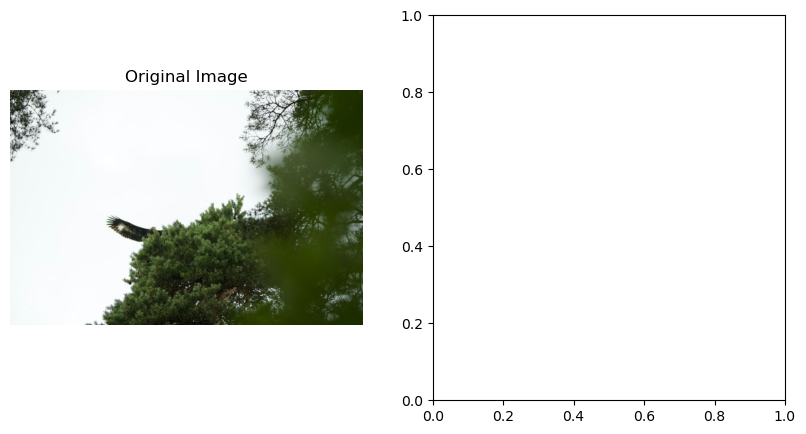

In [25]:
from dataset import ArtportalenDataModule
from model import SimpleModel
from pytorch_lightning import Trainer

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# mean = [0.5, 0.5, 0.5]
# std = [0.5, 0.5, 0.5]

checkpoint = "checkpoints/model-5l05jr5v/last-v5.ckpt"

data = ArtportalenDataModule(data_dir="./testing/images", batch_size=1, size=256, test=True, mean=mean, std=std)
data.prepare_testing_data("./testing/images")
dataloader = data.test_dataloader()

# data = ArtportalenDataModule(data_dir='/Users/amee/Library/CloudStorage/GoogleDrive-ameeassad@gmail.com/My Drive/artportalen_goeag', batch_size=1, size=224)
# data.setup_from_coco('annot/modified_val_annotations.json', 'annot/modified_val_annotations.json')
# dataloader = data.val_dataloader()

model = SimpleModel(model_name="resnet152d", pretrained=False, num_classes=5, outdir="notebook_output")
checkpoint = torch.load(checkpoint, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["state_dict"])


trainer = Trainer(accelerator="cpu")

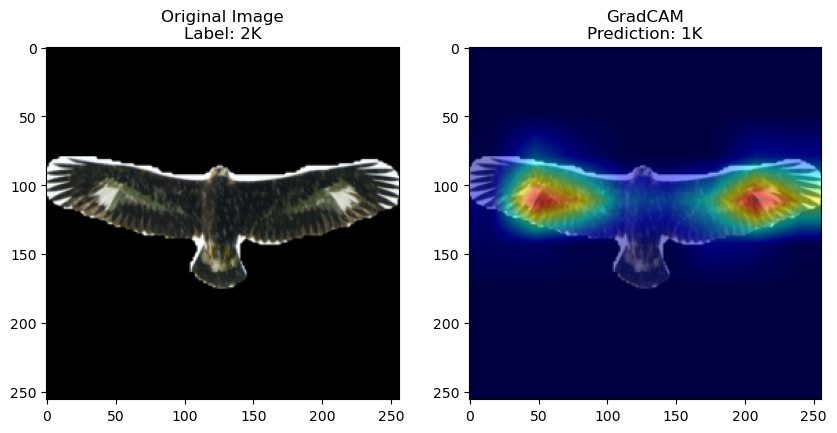

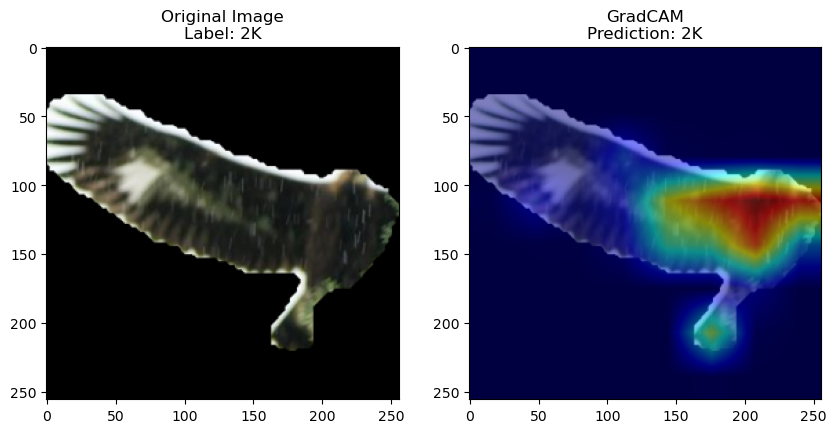

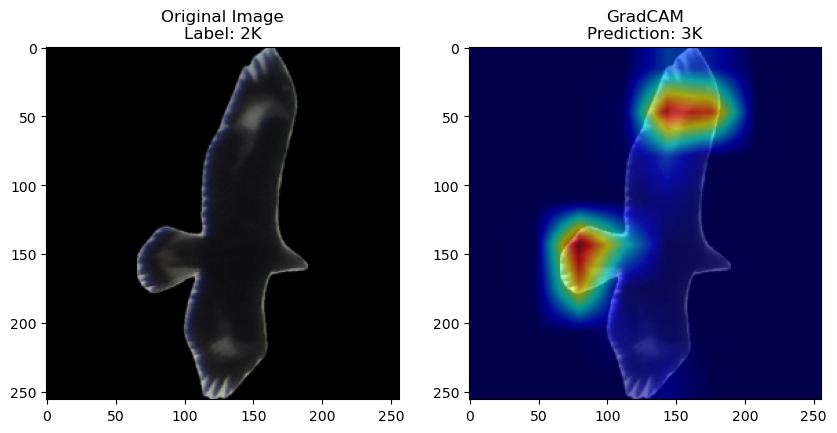

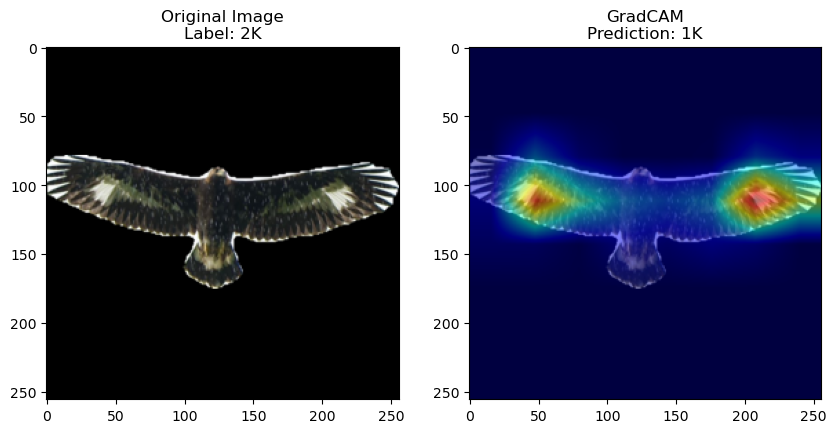

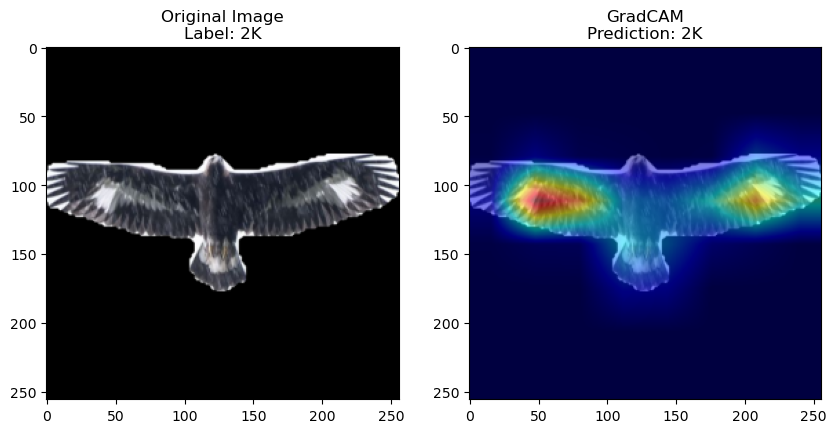

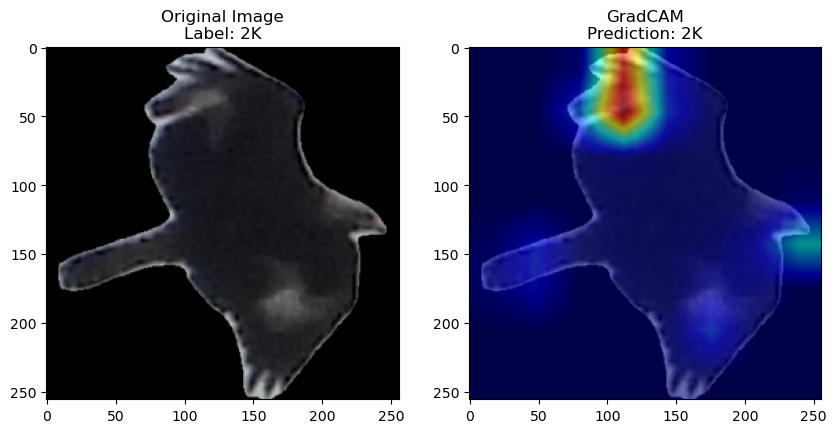

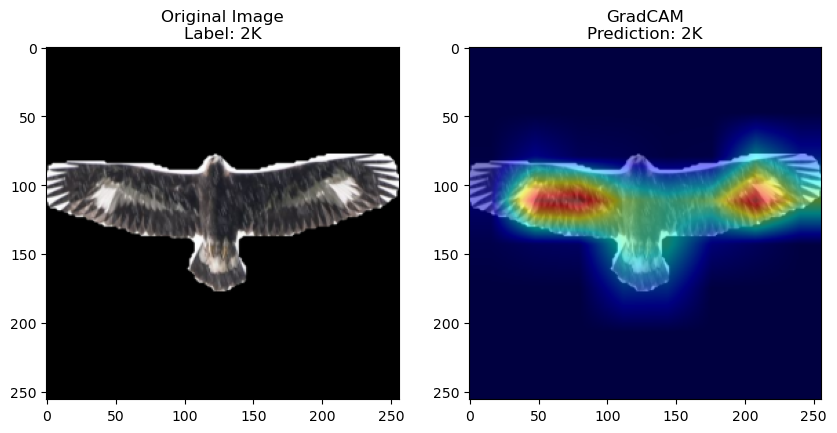

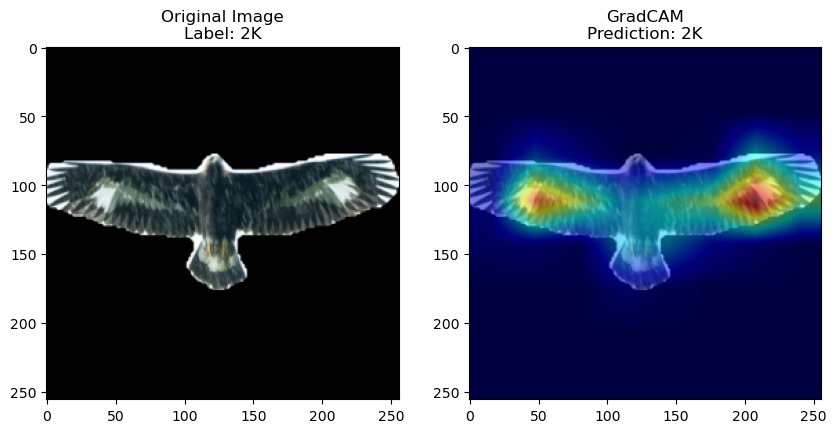

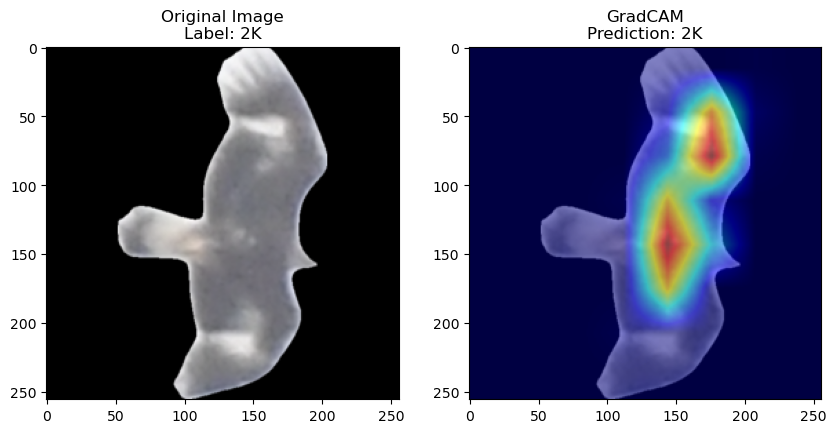

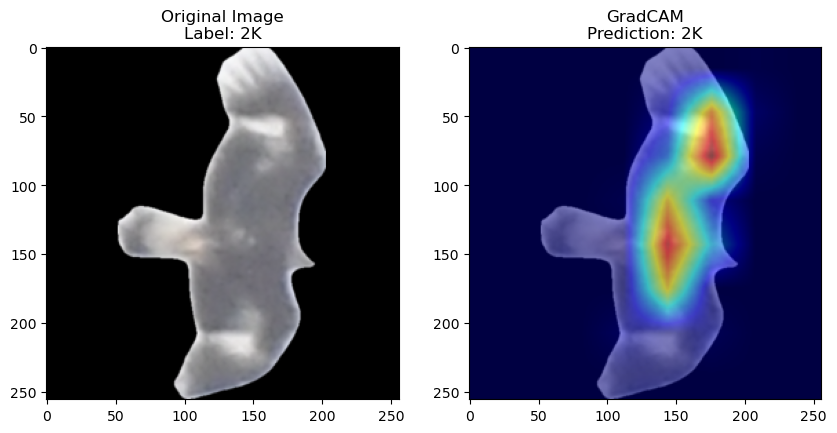

In [26]:
target_layer = model.model.layer4[-1]   # for ResNet

for batch_idx, (images, labels) in enumerate(dataloader):
    for i in range(len(images)):
        image = images[i]
        label = labels[i]

        # Visualize GradCAM
        visualize_gradcam(model, image, label, mean, std, target_layer)


tensor(1)


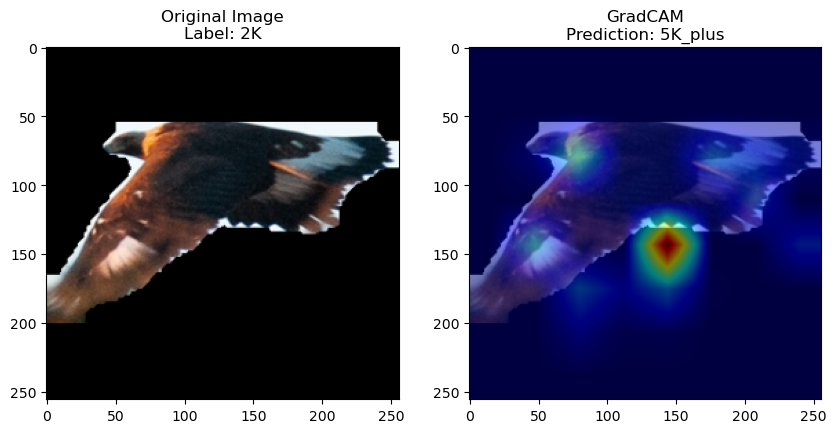

tensor(1)


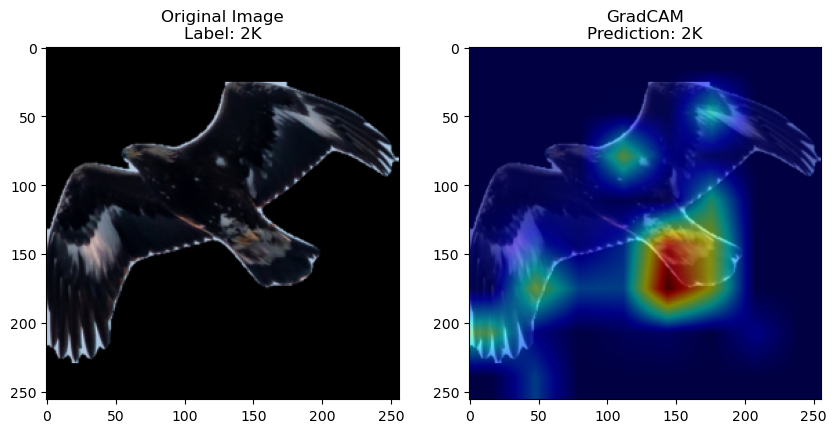

tensor(4)


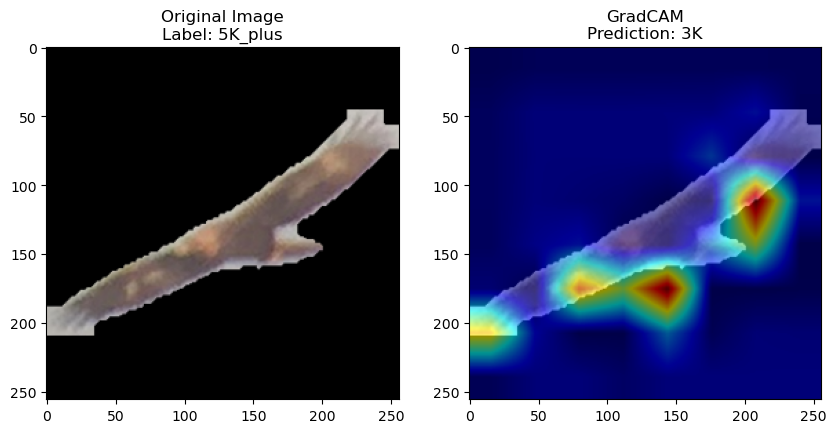

tensor(4)


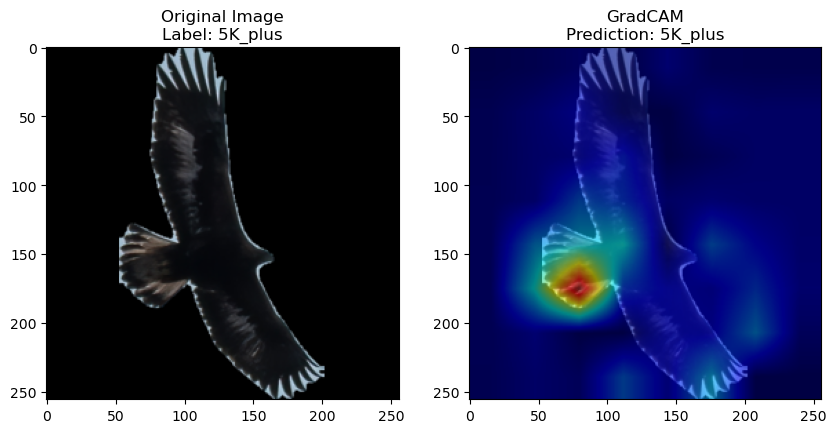

tensor(0)


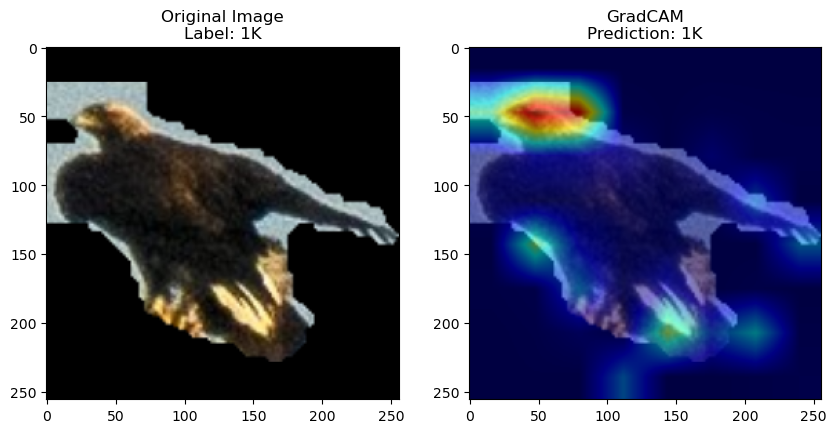

tensor(0)


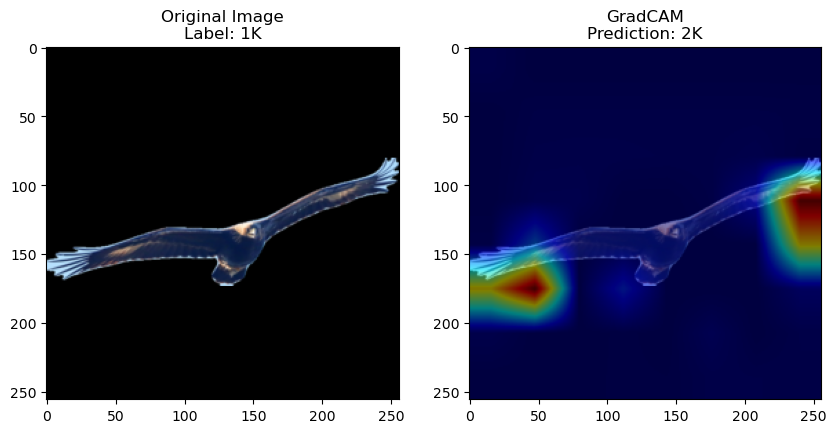

tensor(1)


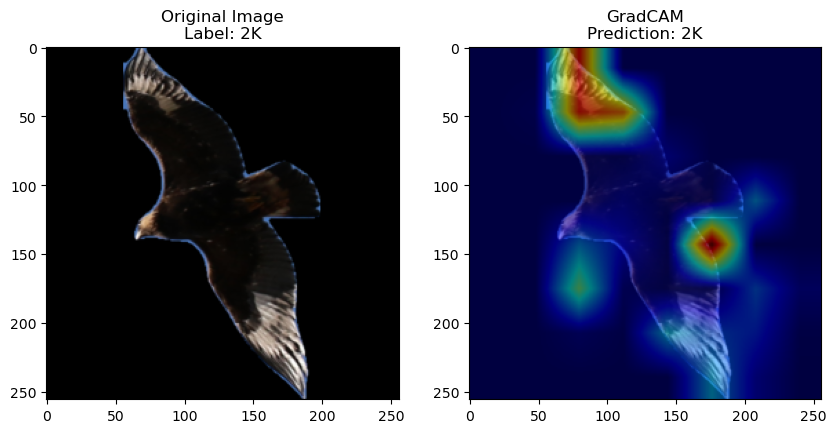

tensor(0)


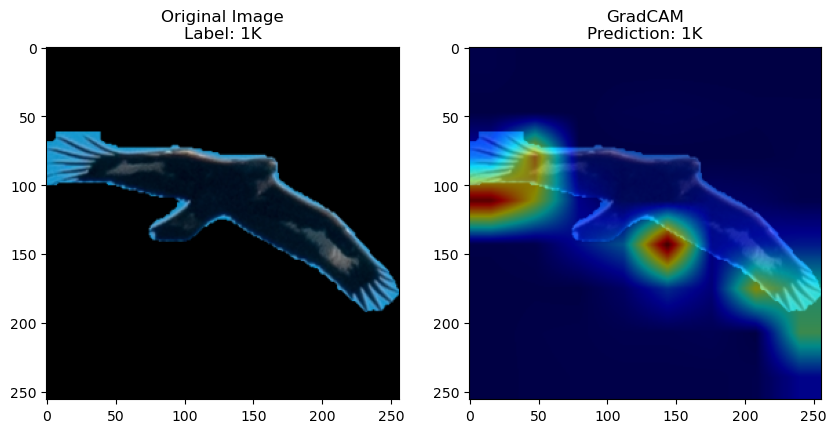

tensor(3)


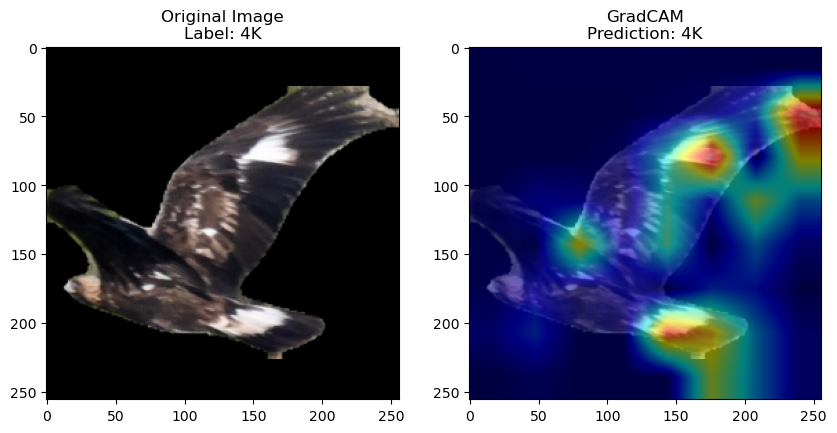

tensor(2)


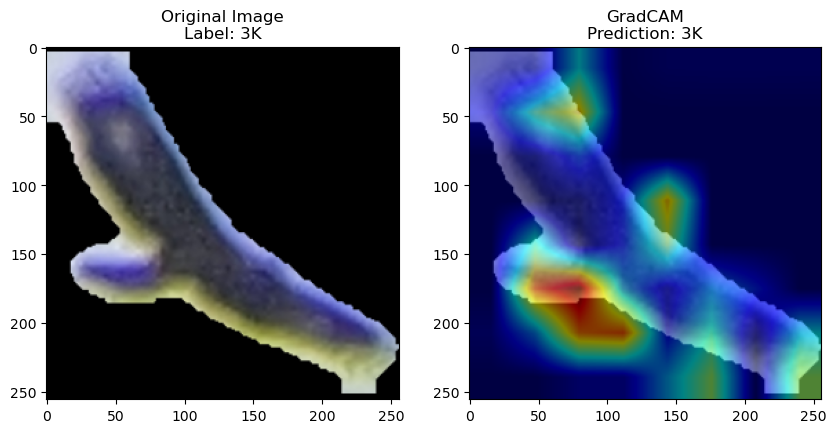

tensor(0)


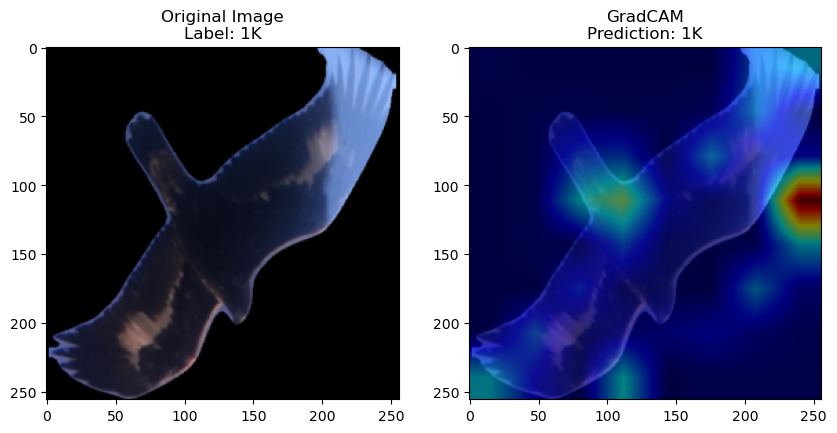

tensor(1)


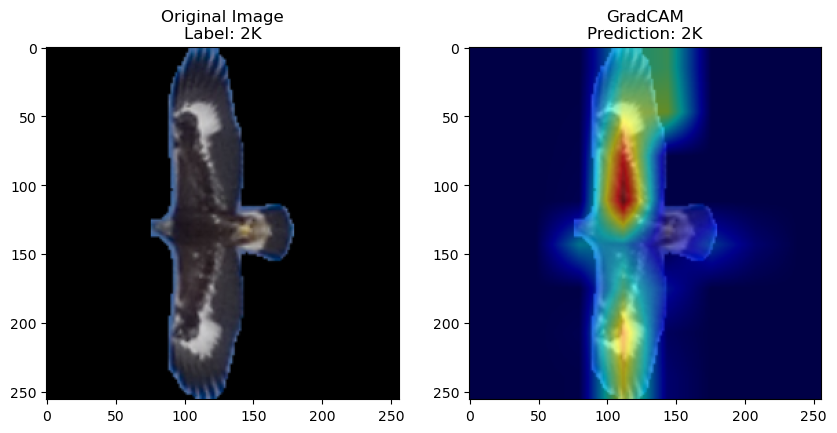

tensor(2)


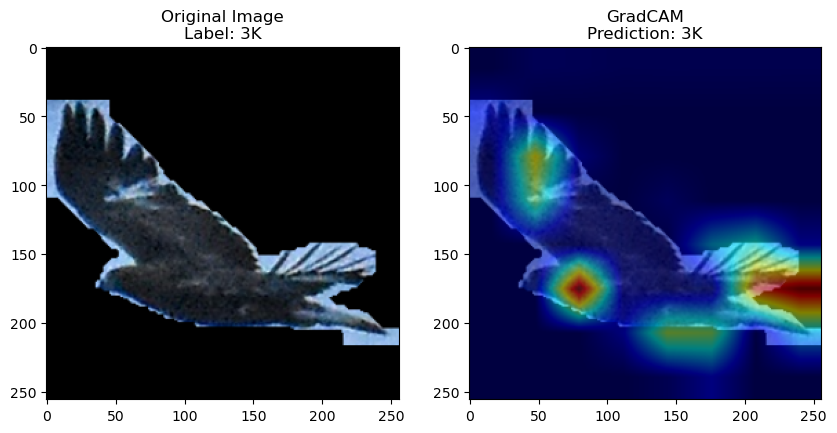

tensor(0)


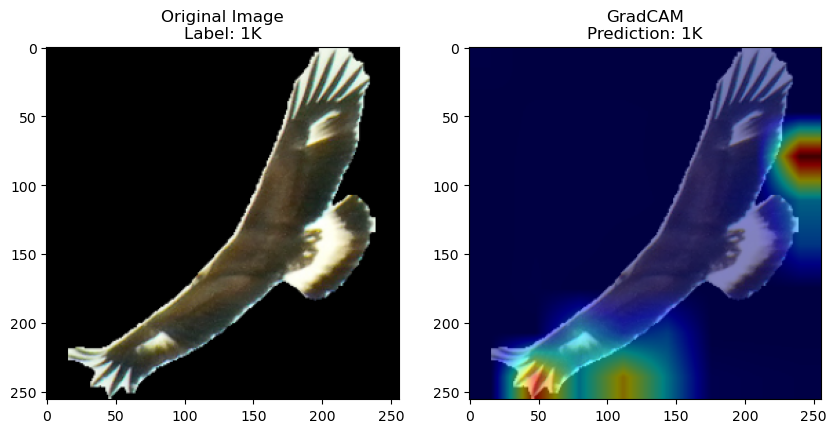

tensor(3)


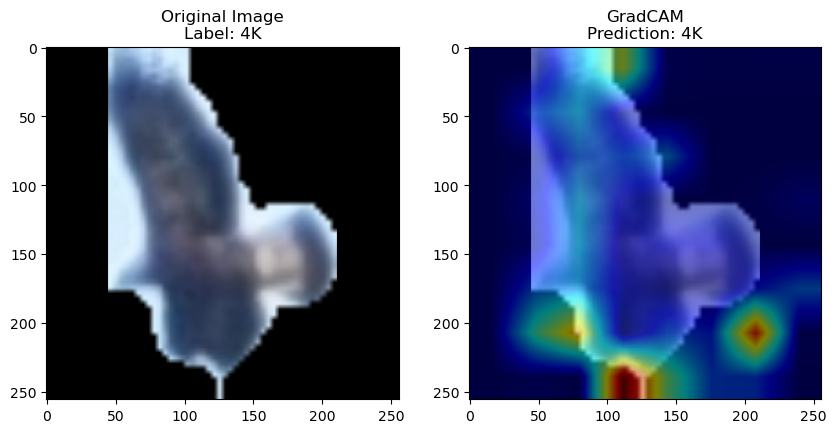

tensor(2)


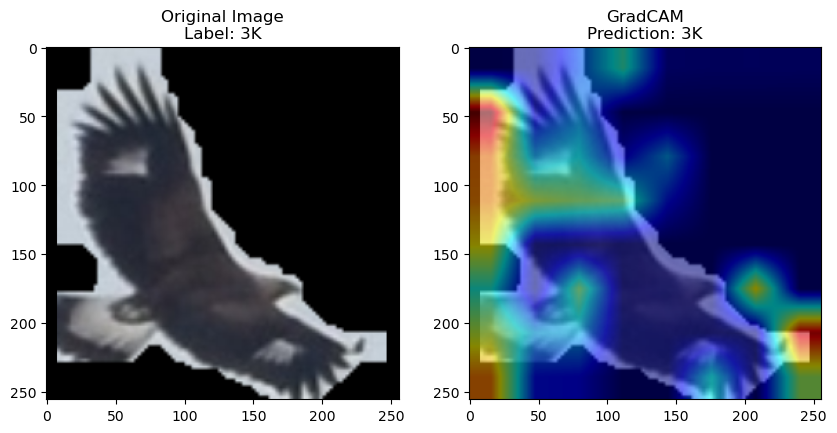

tensor(1)


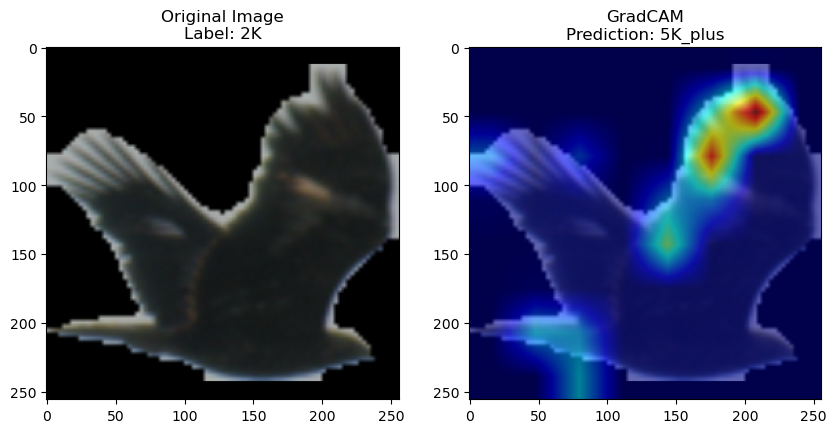

tensor(0)


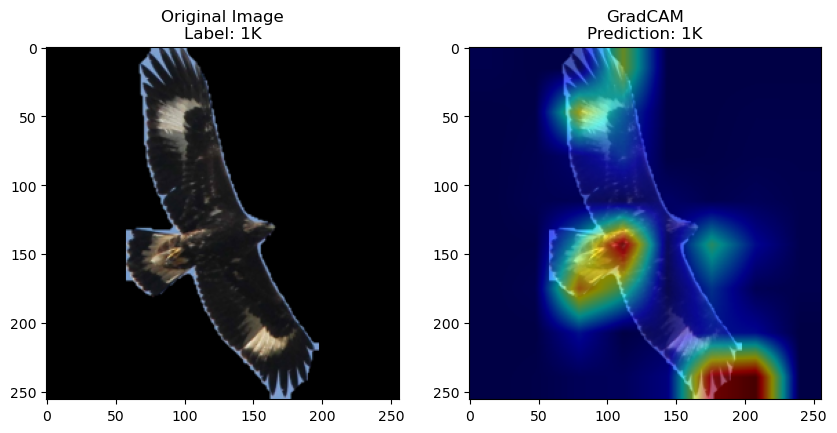

tensor(2)


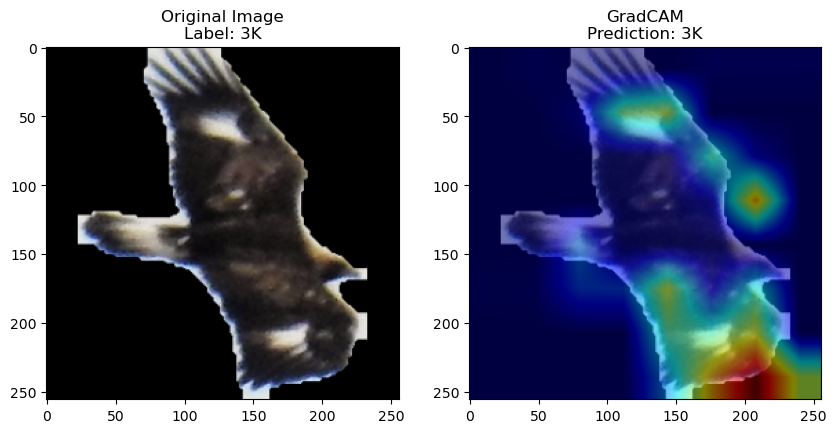

tensor(4)


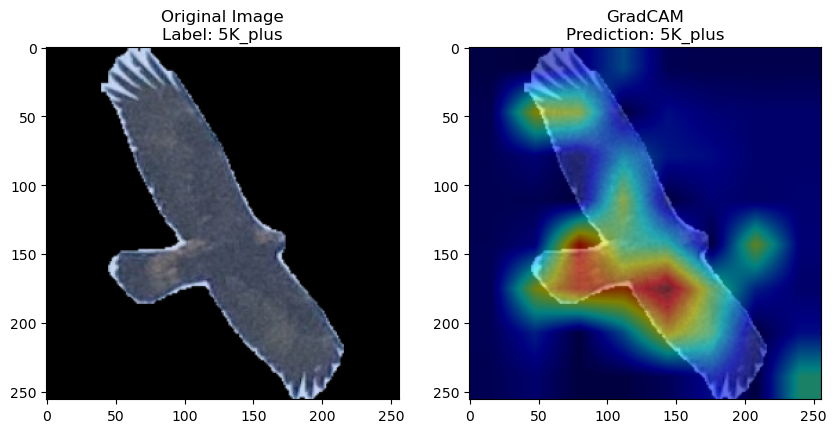

tensor(2)


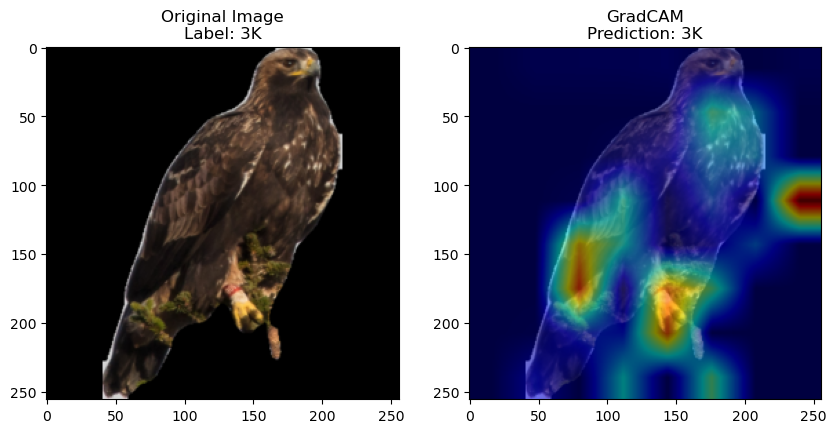

In [15]:
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
target_layer = model.model.layer4[-1]   # for ResNet

for batch_idx, (images, labels) in enumerate(dataloader):
    for i in range(len(images)):
        image = images[i]
        label = labels[i]

        # Visualize GradCAM
        visualize_gradcam(model, image, label, mean, std, target_layer)

    if batch_idx == 20: 
        break